In [1]:
import torch
from PIL import Image
from diffusers import ControlNetModel, DiffusionPipeline, DDIMScheduler
from diffusers.utils import load_image
from torchvision import transforms as tfms

/mnt/disks/main/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img

In [3]:
controlnet = ControlNetModel.from_pretrained('takuma104/control_v11', 
                                             subfolder='control_v11f1e_sd15_tile',
                                             torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    custom_pipeline="invertible_controlnet_img2img",
    controlnet=controlnet,
    torch_dtype=torch.float16).to('cuda')
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.safety_checker = None

/mnt/disks/main/.cache/huggingface/modules/diffusers_modules/local/pipeline.py:26: FutureWarning: Importing `StableDiffusionControlNetPipeline` or `MultiControlNetModel` from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet is deprecated. Please import `from diffusers import StableDiffusionControlNetPipeline` instead.
  from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet import (
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [4]:
frame_1 = load_image('./data/woman_dance_in_street/040.png')
frame_2 = load_image('./data/woman_dance_in_street/050.png')

In [6]:
def invert(
        image, 
        num_inference_steps
    ):
    with torch.no_grad(): latent = pipe.vae.encode((tfms.functional.to_tensor(image).unsqueeze(0).to('cuda')*2-1).half())
    l = 0.18215 * latent.latent_dist.sample()
    inverted_latents = pipe.invert(
        l, 
        prompt="", 
        negative_prompt="",
        guidance_scale=3.5, 
        num_inference_steps=num_inference_steps
    )
    return inverted_latents
def interpolate(inverted_latents, frame_2, cn_scale, start_step, num_inference_steps):
    image = pipe(
        prompt="", 
        negative_prompt="",
        image=frame_2, 
        controlnet_conditioning_image=frame_2, 
        width=frame_2.size[0],
        height=frame_2.size[1],
        strength=1, 
        generator=torch.manual_seed(0),
        num_inference_steps=num_inference_steps, 
        guidance_scale=3.5, 
        controlnet_guidance_end=1,
        controlnet_conditioning_scale=cn_scale,
        latents= inverted_latents[-(start_step + 1)][None],
        start_step=start_step,
    ).images[0]
    return image

In [5]:
num_inference_steps = 50
start_step = 10

In [7]:
inverted_latents = invert(frame_1, num_inference_steps)

 98%|█████████▊| 48/49 [00:07<00:00,  6.03it/s]


In [9]:
# cn_scale_list = [0.01, 0.1, 0.2, 0.5, 1.0]
cn_scale_list = [0.5]

images = []
for i, cn_scale in enumerate(cn_scale_list):
    print(i, cn_scale)
    images.append(
        interpolate(inverted_latents, frame_2, cn_scale, start_step, num_inference_steps)
    )

0 0.5


100%|██████████| 40/40 [00:08<00:00,  4.59it/s]


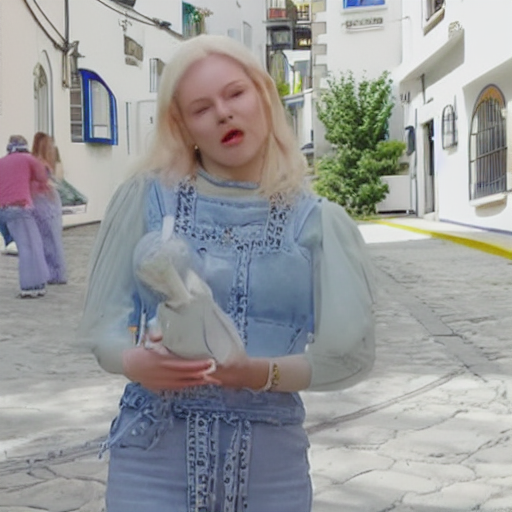

In [10]:
images[0]